In [2]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

In [3]:
HEIGHT = 320
WIDTH = 180

In [4]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2LAB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs

#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [5]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(np.array(pic), dsize=self.size, interpolation=cv2.INTER_NEAREST)


In [6]:
tf = transforms.Compose({
    OpenCVResize(size=(WIDTH, HEIGHT)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
})

gray_dataset = ImageDataset(path='C:/Users/Sachith/Desktop/dataset/faces/grayscale', transform=tf, code=cv2.COLOR_BGR2GRAY)
rgb_dataset = ImageDataset(path='C:/Users/Sachith/Desktop/dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2RGB)
lab_dataset = ImageDataset(path='C:/Users/Sachith/Desktop/dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2LAB)

In [7]:
torch.manual_seed(72)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=10, shuffle=False)
rgb_data_loader = DataLoader(dataset=rgb_dataset, batch_size=10, shuffle=False)
# LAB IMAGES FOR VISUALIZATION AND TRAINING PURPOSE.
lab_data_loader = DataLoader(dataset=lab_dataset, batch_size=10, shuffle=False)
l_data_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=10, shuffle=False)
ab_data_loader = DataLoader(dataset=lab_dataset.ab_images(), batch_size=10, shuffle=False)

#### View a single batch grayscale and colored image sample.

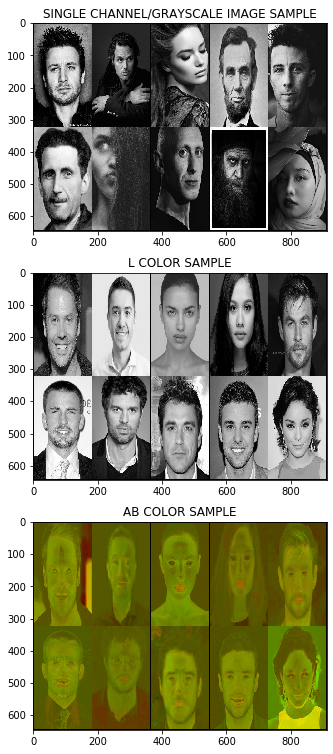

In [8]:
g_ims, l_ims, ab_ims, lab_ims, rgb_ims = (None, None, None, None, None)
for g_ims in gray_data_loader:
    break

for l_ims in l_data_loader:
    break

for ab_ims in ab_data_loader:
    break

for lab_ims in lab_data_loader:
    break

for rgb_ims in rgb_data_loader:
    break

plt.figure(figsize=(14,13))

im = make_grid(g_ims, nrow=5, normalize=True)

plt.subplot(311)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(l_ims, nrow=5, normalize=True)

plt.subplot(312)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title("L COLOR SAMPLE")

im = make_grid(ab_ims, nrow=5, normalize=True)
im = np.stack([im[0], im[1], np.zeros((im.shape[1], im.shape[2]))])

plt.subplot(313)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title('AB COLOR SAMPLE')

plt.show()

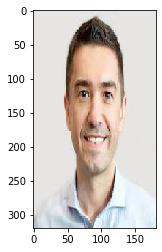

In [9]:
stack = np.stack([l_ims[1][0], ab_ims[1, 0], ab_ims[1, 1]], axis=0)
stack *= 255

stack = np.transpose(stack, (1, 2, 0)).astype(np.uint8)
stack = cv2.cvtColor(stack, code=cv2.COLOR_LAB2RGB)

plt.imshow(stack)

####  Convolutional Neural Network Model

In [12]:
class RGBNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=2, n_layers=(128, 64, 32, 32)):
        super().__init__()

        layers = []

        for i, nl in enumerate(n_layers):
            i += 1

            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=nl,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1))
            layers.append(nn.BatchNorm2d(nl))
            layers.append(nn.ReLU())

            if i % 2 == 0:
                layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
                layers.append(nn.Upsample(scale_factor=2))

            in_channels = nl

        layers.append(nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=3,
                                stride=1,
                                padding=1))

        self.sequence = nn.Sequential(*layers)

    def forward(self, X):
        return self.sequence(X)


model = RGBNet()
model

RGBNet(
  (sequence): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Upsample(scale_factor=2.0, mode=nearest)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Upsample(scale_factor=2.0, mode=nearest)
    (16): Conv2d(32, 2, kern

tensor(0.8588) tensor(-0.6039)


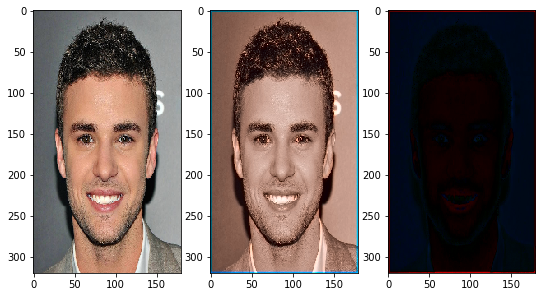

In [19]:
IMG_INDEX = 8

model.eval()
with torch.no_grad():
    plt.figure(figsize=(9, 8))
    plt.subplot(131)
    plt.imshow(np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0)))

    s = model(l_ims[IMG_INDEX].view(-1, 1, HEIGHT, WIDTH))
    s = torch.stack([l_ims[IMG_INDEX][0], s[0, 0], s[0, 1]]) * 255
    s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
    s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

    plt.subplot(132)
    plt.imshow(s)

    org = np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0))
    pred = torch.Tensor(s) / 255

    diff = torch.sub(input=org, other=pred)

    print(diff.max(), diff.min())

    plt.subplot(133)
    plt.imshow(diff)

#### Training Neural Network Models


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
epoch = 5
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    batch_time = time.time()

    for batch, (X, y) in enumerate(zip(l_data_loader, ab_data_loader)):
        batch += 1

        y_pred = model(X)
        loss = criterion(y_pred, y)

        losses.append(loss)

        if batch % 2 == 0 or batch == 1:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.28712019324302673
Epoch: 1, Batch: 2 -> Loss: 0.1917315125465393
Epoch: 1, Batch: 4 -> Loss: 0.0971100777387619
Epoch: 1, Batch: 6 -> Loss: 0.015432586893439293
Epoch: 1, Batch: 8 -> Loss: 0.02556106261909008
Epoch: 1, Batch: 10 -> Loss: 0.012452226132154465
Epoch: 2, Batch: 1 -> Loss: 0.012251012958586216
Epoch: 2, Batch: 2 -> Loss: 0.012828410603106022
Epoch: 2, Batch: 4 -> Loss: 0.005763528868556023
Epoch: 2, Batch: 6 -> Loss: 0.00898322369903326
Epoch: 2, Batch: 8 -> Loss: 0.006453481037169695
Epoch: 2, Batch: 10 -> Loss: 0.007524057291448116
Epoch: 3, Batch: 1 -> Loss: 0.00621379166841507
Epoch: 3, Batch: 2 -> Loss: 0.004864884074777365
Epoch: 3, Batch: 4 -> Loss: 0.006852897349745035
Epoch: 3, Batch: 6 -> Loss: 0.004349286202341318
Epoch: 3, Batch: 8 -> Loss: 0.005261566024273634
Epoch: 3, Batch: 10 -> Loss: 0.0032264823094010353
Epoch: 4, Batch: 1 -> Loss: 0.00459126615896821
Epoch: 4, Batch: 2 -> Loss: 0.004495784640312195
Epoch: 4, Batch: 4 -> Los

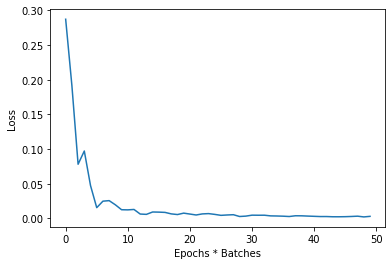

In [16]:
plt.plot(losses)
plt.xlabel('Epochs * Batches')
plt.ylabel('Loss')

del losses

#### Validate images with same dataset used to train.

In [17]:
@torch.no_grad()
def validate(img):

    model.eval()

    ab = model(img)

    lab = np.stack([img[0, 0], ab[0, 0], ab[0, 1]], axis=0) * 255

    lab = np.transpose(lab, axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    plt.imshow(lab)

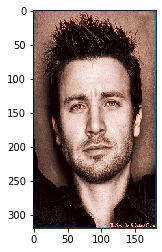

In [18]:
validate(g_ims[0].view(-1, 1, HEIGHT, WIDTH))